In [0]:
!pip install -q tensorflow-gpu==2.0.0-rc2

In [2]:
import tensorflow as tf
tf.__version__

'2.0.0-rc2'

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

from tqdm import tqdm
from tqdm import trange

print(tf.executing_eagerly())

True


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def imgLoad(folder, shape, gray = True):
    im_dir = os.path.join("/content/drive/My Drive", folder)
    tmp = []

    file_list = os.listdir(im_dir)
    file_list = sorted(file_list, key = str.lower)

    for name in tqdm(file_list):
        path = os.path.join(im_dir, name)
        print(path)
        if gray:
            im = cv2.imread(path, 0)
            im = np.expand_dims(im, -1)
        else:
            im = cv2.imread(path)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = cv2.resize(im, dsize = shape[:2])
        tmp.append(im)

    return np.array(tmp)

In [0]:
size = 256

In [7]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
def model(input_shape, output_shape, kernel_size, stride, pad='same', bias=False, init=tf.initializers.he_normal()):
    inputs = layers.Input(shape=input_shape, name='input')

    #block1
    first = layers.Conv2D(64, kernel_size, strides=(2, 2), activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(0.01), name='first1')(inputs)
    first = layers.Conv2D(64, kernel_size, strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(0.01), name='first2')(first)
    first_pool = layers.MaxPool2D((2, 2), name='first_pool')(first)

    # block2
    second = layers.Conv2D(128, kernel_size, strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(0.01), name='second1')(first_pool)
    second = layers.Conv2D(128, kernel_size, strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(0.01), name='second2')(second)
    second_pool = layers.MaxPool2D((2, 2), name='second_pool')(second)

    # block3
    third = layers.Conv2D(256, kernel_size, strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(0.01), name='third1')(second_pool)
    third = layers.Conv2D(256, kernel_size, strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(0.01), name='third2')(third)
    third = layers.Conv2D(256, kernel_size, strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(0.01), name='third3')(third)
    third_pool = layers.MaxPool2D((2, 2), name='third_pool')(third)

    # bloack4
    forth = layers.Conv2D(512, kernel_size, strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(0.01), name='forth1')(third_pool)
    forth = layers.Conv2D(512, kernel_size, strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(0.01), name='forth2')(forth)
    forth = layers.Conv2D(512, kernel_size, strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(0.01), name='forth3')(forth)
    forth_pool = layers.MaxPool2D((2, 2), name='forth_pool')(forth)

    # bloack5
    fifth = layers.Conv2D(512, kernel_size, strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(0.01), name='fifth1')(forth_pool)
    fifth = layers.Conv2D(512, kernel_size, strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(0.01), name='fifth2')(fifth)
    fifth = layers.Conv2D(512, kernel_size, strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(0.01), name='fifth3')(fifth)
    fifth_pool = layers.MaxPool2D((2, 2), name='fifth_pool')(fifth)

    # bloack6
    sixth = layers.Conv2D(4096, kernel_size=(fifth_pool.shape[1],fifth_pool.shape[1]), strides=stride, activation='relu', padding='valid', use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(0.01), name='sixth')(fifth_pool)
    sixth = layers.Dropout(0.5)(sixth)

    # bloack7
    seventh = layers.Conv2D(4096, kernel_size=(1, 1), strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(0.01), name='seventh')(sixth)
    seventh = layers.Dropout(0.5)(seventh)

    # # Upsampling
    de_seventh = layers.Conv2DTranspose(512, kernel_size, strides=(forth_pool.shape[1], forth_pool.shape[1]), padding=pad, use_bias=bias, kernel_initializer=init, name='de_seventh')(seventh)
    fcn16 = layers.Add()([de_seventh, forth_pool])
    de_fcn16 = layers.Conv2DTranspose(256, kernel_size, strides=(2, 2), padding=pad, use_bias=bias, kernel_initializer=init, name='de_fcn16')(fcn16)

    output = layers.Add()([de_fcn16, third_pool])

    output =  pix2pix.upsample(512, 3)(output)
    output = layers.Conv2DTranspose(64, kernel_size, strides=(1, 1), padding=pad, use_bias=bias, kernel_initializer=init, name='output1_2')(output)
    output = layers.Conv2DTranspose(64, kernel_size, strides=(1, 1), padding=pad, use_bias=bias, kernel_initializer=init, name='output1_3')(output)

    output = pix2pix.upsample(256, 3)(output)
    output = layers.Conv2DTranspose(32, kernel_size, strides=(1, 1), padding=pad, use_bias=bias, kernel_initializer=init, name='output2_2')(output)
    output = layers.Conv2DTranspose(32, kernel_size, strides=(1, 1), padding=pad, use_bias=bias, kernel_initializer=init, name='output2_3')(output)

    output = pix2pix.upsample(128, 3)(output)
    output = layers.Conv2DTranspose(16, kernel_size, strides=(1, 1), padding=pad, use_bias=bias, kernel_initializer=init, name='output3_2')(output)
    output = layers.Conv2DTranspose(16, kernel_size, strides=(1, 1), padding=pad, use_bias=bias, kernel_initializer=init, name='output3_3')(output)

    output = pix2pix.upsample(64, 3)(output)
    output = layers.Conv2DTranspose(3, kernel_size, strides=(1, 1), padding=pad, use_bias=bias, kernel_initializer=init, name='output4_2')(output)
    output = layers.Conv2DTranspose(3, kernel_size, strides=(1, 1), padding=pad, use_bias=bias, kernel_initializer=init, name='output4_3')(output)

    output = layers.Conv2D(output_shape, kernel_size, strides=(1, 1), padding=pad, use_bias=bias, kernel_initializer=init, name='output5')(output)

    return tf.keras.Model(inputs=inputs, outputs=output, name='Semantic')

In [9]:
!pip install -q git+https://github.com/tensorflow/examples.git

from tensorflow_examples.models.pix2pix import pix2pix

In [0]:
# def model(inputs_shape, output_channels):
#     base_model = tf.keras.applications.MobileNetV2(input_shape=inputs_shape, include_top=False)

#     # Use the activations of these layers
#     layer_names = [
#         'block_1_expand_relu',   # 64x64
#         'block_3_expand_relu',   # 32x32
#         'block_6_expand_relu',   # 16x16
#         'block_13_expand_relu',  # 8x8
#         'block_16_project',      # 4x4
#     ]
#     layers = [base_model.get_layer(name).output for name in layer_names]

#     # Create the feature extraction model
#     down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
#     down_stack.trainable = False

#     up_stack = [
#     pix2pix.upsample(512, 3),  # 4x4 -> 8x8
#     pix2pix.upsample(256, 3),  # 8x8 -> 16x16
#     pix2pix.upsample(128, 3),  # 16x16 -> 32x32
#     pix2pix.upsample(64, 3),   # 32x32 -> 64x64
#     ]

#     last = tf.keras.layers.Conv2DTranspose(
#       output_channels, 3, strides=2,
#       padding='same', activation='softmax')  #64x64 -> 128x128

#     inputs = tf.keras.layers.Input(shape=inputs_shape)
#     x = inputs

#     # Downsampling through the model
#     skips = down_stack(x)
#     x = skips[-1]
#     skips = reversed(skips[:-1])

#     # Upsampling and establishing the skip connections
#     for up, skip in zip(up_stack, skips):
#         x = up(x)
#         concat = tf.keras.layers.Concatenate()
#         x = concat([x, skip])

#     x = last(x)

#     return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
size = 64
#test_model = model((size, size, 3), 3)

In [0]:
# print(test_model.summary())
# keras.utils.plot_model(test_model, 'Semantic Segmentation Model.png', show_shapes = True, expand_nested=False, dpi=48)

In [0]:
# test_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

In [0]:
test_model = model((size, size, 3), 1, (3, 3), stride=(1, 1), bias=True)

In [15]:
test_model.summary()

Model: "Semantic"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
first1 (Conv2D)                 (None, 32, 32, 64)   1792        input[0][0]                      
__________________________________________________________________________________________________
first2 (Conv2D)                 (None, 32, 32, 64)   36928       first1[0][0]                     
__________________________________________________________________________________________________
first_pool (MaxPooling2D)       (None, 16, 16, 64)   0           first2[0][0]                     
___________________________________________________________________________________________

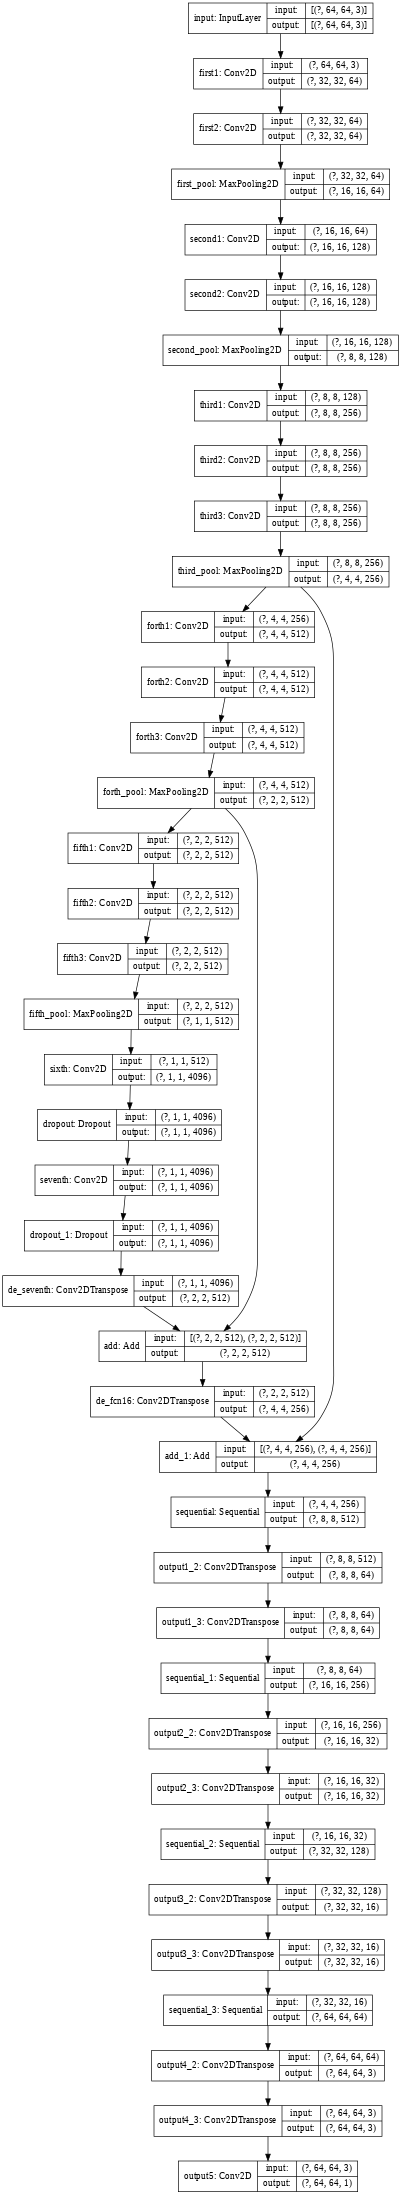

In [16]:
keras.utils.plot_model(test_model, 'Semantic Segmentation Model.png', show_shapes = True, expand_nested=False, dpi=48)

In [0]:
# def model(input_shape, kernel_size, stride, pad='same', bias=False, init=tf.initializers.he_normal(), L2=0.01):
#     inputs = layers.Input(shape=input_shape, name='input')

#     #block1
#     first = layers.Conv2D(64, kernel_size, strides=(2, 2), activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='first1')(inputs)
#     first = layers.Conv2D(64, kernel_size, strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='first2')(first)
#     first_pool = layers.MaxPool2D((2, 2), name='first_pool')(first)

#     # block2
#     second = layers.Conv2D(128, kernel_size, strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='second1')(first_pool)
#     second = layers.Conv2D(128, kernel_size, strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='second2')(second)
#     second_pool = layers.MaxPool2D((2, 2), name='second_pool')(second)

#     # block3
#     third = layers.Conv2D(256, kernel_size, strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='third1')(second_pool)
#     third = layers.Conv2D(256, kernel_size, strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='third2')(third)
#     third = layers.Conv2D(256, kernel_size, strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='third3')(third)
#     third_pool = layers.MaxPool2D((2, 2), name='third_pool')(third)

#     # bloack4
#     forth = layers.Conv2D(512, kernel_size, strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='forth1')(third_pool)
#     forth = layers.Conv2D(512, kernel_size, strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='forth2')(forth)
#     forth = layers.Conv2D(512, kernel_size, strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='forth3')(forth)
#     forth_pool = layers.MaxPool2D((2, 2), name='forth_pool')(forth)

#     # bloack5
#     fifth = layers.Conv2D(512, kernel_size, strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='fifth1')(forth_pool)
#     fifth = layers.Conv2D(512, kernel_size, strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='fifth2')(fifth)
#     fifth = layers.Conv2D(512, kernel_size, strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='fifth3')(fifth)
#     fifth_pool = layers.MaxPool2D((2, 2), name='fifth_pool')(fifth)

#     # bloack6
#     sixth = layers.Conv2D(4096, kernel_size=(3, 3), strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='sixth')(fifth_pool)
#     sixth = layers.Dropout(0.5)(sixth)

#     # bloack7
#     seventh = layers.Conv2D(4096, kernel_size=(1, 1), strides=stride, activation='relu', padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='seventh')(sixth)
#     seventh = layers.Dropout(0.5)(seventh)

#     eighth = layers.Conv2D(2, kernel_size=(1, 1), strides=stride, kernel_initializer='he_normal', activation='linear', padding='valid', kernel_regularizer=keras.regularizers.l2(L2), name='x')(seventh)

#     # # Upsampling
#     ninth_unpool = layers.Conv2DTranspose(512, kernel_size, strides=(2, 2), padding=pad, use_bias=bias, kernel_initializer=init, name='ninth_unpool')(eighth)
#     ninth = layers.Conv2DTranspose(512, kernel_size, strides=(1, 1), padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='ninth1')(ninth_unpool)
#     ninth = layers.Conv2DTranspose(512, kernel_size, strides=(1, 1), padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='ninth2')(ninth)
#     ninth = layers.Conv2DTranspose(512, kernel_size, strides=(1, 1), padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='ninth3')(ninth)

#     tenth_unpool = layers.Conv2DTranspose(512, kernel_size, strides=(2, 2), padding=pad, use_bias=bias, kernel_initializer=init, name='tenth_unpool')(ninth)
#     tenth = layers.Conv2DTranspose(512, kernel_size, strides=(1, 1), padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='tenth1')(tenth_unpool)
#     tenth = layers.Conv2DTranspose(512, kernel_size, strides=(1, 1), padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='tenth2')(tenth)
#     tenth = layers.Conv2DTranspose(512, kernel_size, strides=(1, 1), padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='tenth3')(tenth)

#     eleventh_unpool = layers.Conv2DTranspose(512, kernel_size, strides=(2, 2), padding=pad, use_bias=bias, kernel_initializer=init, name='eleventh_unpool')(tenth)
#     eleventh = layers.Conv2DTranspose(512, kernel_size, strides=(1, 1), padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='eleventh1')(eleventh_unpool)
#     eleventh = layers.Conv2DTranspose(512, kernel_size, strides=(1, 1), padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='eleventh2')(eleventh)
#     eleventh = layers.Conv2DTranspose(512, kernel_size, strides=(1, 1), padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='eleventh3')(eleventh)

#     twelveth_unpool = layers.Conv2DTranspose(256, kernel_size, strides=(2, 2), padding=pad, use_bias=bias, kernel_initializer=init, name='twelveth_unpool')(eleventh)
#     twelveth = layers.Conv2DTranspose(256, kernel_size, strides=(1, 1), padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='twelveth1')(twelveth_unpool)
#     twelveth = layers.Conv2DTranspose(256, kernel_size, strides=(1, 1), padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='twelveth2')(twelveth)
#     twelveth = layers.Conv2DTranspose(256, kernel_size, strides=(1, 1), padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='twelveth3')(twelveth)

#     thirteenth_unpool = layers.Conv2DTranspose(128, kernel_size, strides=(2, 2), padding=pad, use_bias=bias, kernel_initializer=init, name='thirteenth_unpool')(twelveth)
#     thirteenth = layers.Conv2DTranspose(128, kernel_size, strides=(1, 1), padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='thirteenth1')(thirteenth_unpool)
#     thirteenth = layers.Conv2DTranspose(128, kernel_size, strides=(1, 1), padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='thirteenth2')(thirteenth)

#     fourteenth_unpool = layers.Conv2DTranspose(64, kernel_size, strides=(2, 2), padding=pad, use_bias=bias, kernel_initializer=init, name='fourteenth_unpool')(thirteenth)
#     fourteenth = layers.Conv2DTranspose(64, kernel_size, strides=(1, 1), padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='fourteenth1')(fourteenth_unpool)
#     fourteenth = layers.Conv2DTranspose(64, kernel_size, strides=(1, 1), padding=pad, use_bias=bias, kernel_initializer=init, kernel_regularizer=keras.regularizers.l2(L2), name='fourteenth2')(fourteenth)

#     output = layers.Conv2DTranspose(1, kernel_size, strides=(1, 1), padding=pad, use_bias=bias, kernel_initializer=init, name='output')(fourteenth)
#     return tf.keras.Model(inputs=inputs, outputs=output, name='Semantic')

In [0]:
import datetime

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
# test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
# test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [0]:
train_loss = keras.metrics.Mean('train_loss', dtype=tf.float32)
train_acc = keras.metrics.Mean('train_accuracy', dtype=tf.float32)
# train_acc = keras.metrics.Accuracy("train_acc")
# test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)

In [0]:
model_optimizer = keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-4)

In [0]:
def model_loss(predict_mask, true_mask):
    predict_mask = keras.layers.Reshape((size, size))(predict_mask)

    # pixel_wise = keras.layers.subtract([predict_mask, true_mask])
    # pixel_wise = keras.backend.abs(keras.layers.subtract([predict_mask, true_mask]))
    # return keras.losses.MeanAbsoluteError()(y_true=tf.zeros_like(pixel_wise), y_pred=pixel_wise)
    # return tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(pixel_wise), logits=pixel_wise)
    
    # return keras.losses.MeanSquaredError()(y_true=true_mask, y_pred=predict_mask)
    # return keras.losses.SparseCategoricalCrossentropy()(y_true=true_mask, y_pred=predict_mask)
    # return keras.losses.MeanSquaredLogarithmicError()(y_true=true_mask, y_pred=predict_mask)
    return keras.losses.MeanAbsoluteError()(y_true=true_mask, y_pred=predict_mask)


def model_acc(predict_mask, true_mask):
    predict_mask = keras.layers.Reshape((size, size))(predict_mask)

    intersection = np.logical_and(true_mask.numpy(), predict_mask.numpy())
    union = np.logical_or(true_mask.numpy(), predict_mask.numpy())
    iou_score = np.sum(intersection) / np.sum(union)

    return iou_score

In [0]:
# def model_acc(predict_mask, true_mask, threshold):
#     predict_mask = tf.squeeze(predict_mask, axis=-1)

#     pixel_wise = keras.backend.abs(pixel_wise = keras.layers.subtract([predict_mask, true_mask]))
#     pixel_maks = (pixel_wise < 50)


In [0]:
#@tf.function
def train_step(model, imgs, mask):
    with tf.GradientTape() as tape:
        predict = model(imgs, training=True)
        loss = model_loss(predict, mask)
        acc = model_acc(predict, mask)
        # print(loss)

    gradient = tape.gradient(loss, model.trainable_variables)
    model_optimizer.apply_gradients(zip(gradient, model.trainable_variables))

    train_loss(loss)
    train_acc(acc)
    return loss

In [0]:
# datagen = ImageDataGenerator(rotation_range=5, horizontal_flip=True, vertical_flip=True, height_shift_range=0.2, width_shift_range=0.2)
# datagen = ImageDataGenerator(rotation_range=5)

In [24]:
from time import sleep

shape = (size, size, 3) 
train_images = imgLoad('workspace/Python/ML_Basic/Images/trainImg', shape, False)
train_truth = imgLoad('workspace/Python/ML_Basic/Images/GroundTruth', shape, True)

  9%|▊         | 13/151 [00:00<00:01, 120.71it/s]

/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/106024.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/153077.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/153093.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/181079.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/189080.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/208001.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/209070.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/21077.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/227092.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/24077.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/271008.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/304074.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/326038.jpg
/

 26%|██▌       | 39/151 [00:00<00:00, 121.64it/s]

/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/baby_2007_006647.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/baby_2007_007203.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/banana1.bmp
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/banana2.bmp
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/banana3.bmp
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/bike_2007_000364.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/bike_2007_000822.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/bike_2007_004003.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/bike_2007_005354.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/bike_2007_005878.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/bike_2007_008994.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/bike

 42%|████▏     | 63/151 [00:00<00:00, 117.91it/s]

/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/bus_2007_003101.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/bus_2007_003503.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/bus_2007_003786.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/bus_2007_005262.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/bush.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/car_2007_006900.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/car_2007_009779.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/car_2008_000595.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/car_2008_001716.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/car_2008_002834.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/cat_2007_000528.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg

 56%|█████▋    | 85/151 [00:00<00:00, 100.86it/s]

/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/doll.bmp
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/elefant.bmp
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/flower.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/fullmoon.bmp
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/grave.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/GT02.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/GT07.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/GT13.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/horse_2007_003889.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/horse_2007_006134.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/horse_2008_000696.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/llama.bmp
/content/drive/My Drive/workspace/Python/ML_Basic/

 70%|███████   | 106/151 [00:00<00:00, 100.53it/s]

/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/music.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/person1.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/person2.bmp
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/person3.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/person4.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/person5.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/person6.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/person7.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/person8.bmp
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/person_2007_000170.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/person_2007_000323.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/person_2007_000392.jpg
/content/drive/My Drive/workspace

 85%|████████▌ | 129/151 [00:01<00:00, 104.53it/s]

/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/person_2007_002823.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/person_2007_004328.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/person_2007_004722.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/person_2007_005086.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/person_2007_005430.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/person_2007_006364.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/person_2007_007996.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/person_2007_008218.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/person_2007_009327.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/person_2007_009687.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/person_2008_000474.jpg
/content/drive/My Dri

  0%|          | 0/151 [00:00<?, ?it/s]

/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/sheep_2007_001416.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/sheep_2007_003593.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/sofa_2007_000661.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/sofa_2007_001149.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/sofa_2007_006530.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/stone1.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/stone2.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/teddy.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/tennis.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/train_2007_000042.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/train_2007_000333.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/train_2007_002

 30%|███       | 46/151 [00:00<00:00, 233.89it/s]

/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/aero_2007_000032.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/aero_2007_001884.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/aero_2007_006232.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/aero_2007_007341.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/aero_2007_009030.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/aero_2008_002358.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/baby_2007_005227.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/baby_2007_006647.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/baby_2007_007203.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/banana1.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/banana2.png
/content/drive/My Drive/work

 54%|█████▎    | 81/151 [00:00<00:00, 196.79it/s]

/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/car_2008_000595.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/car_2008_001716.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/car_2008_002834.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/cat_2007_000528.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/cat_2007_000876.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/cat_2007_001185.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/cat_2007_007530.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/cat_2008_000345.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/cat_2008_001592.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/cat_2008_001885.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/ceramic.png
/content/drive/My Drive/works

 79%|███████▉  | 119/151 [00:00<00:00, 192.34it/s]

/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/person2.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/person3.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/person4.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/person5.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/person6.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/person7.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/person8.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/person_2007_000170.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/person_2007_000323.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/person_2007_000392.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/person_2007_000480.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTr

100%|██████████| 151/151 [00:00<00:00, 184.76it/s]

/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/plant_2008_000391.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/plant_2008_002273.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/plant_2008_002379.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/scissors.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/sheep.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/sheep_2007_001416.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/sheep_2007_003593.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/sofa_2007_000661.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/sofa_2007_001149.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/sofa_2007_006530.png
/content/drive/My Drive/workspace/Python/ML_Basic/Images/GroundTruth/stone1.png
/content/drive/My Drive/workspace/

In [0]:
!pip install -q tqdm

In [0]:
import random
from scipy import ndimage
from tqdm import tqdm
from tqdm import trange
from time import sleep

def data_augmentation(images, labels):
    aug_images = []
    aug_labels = []    
    
    cnt = 1
    for x, y in tqdm(zip(images, labels), total=images.shape[0]):

        aug_images.append(x)
        aug_labels.append(y)
        bg_value = np.median(x)
        
        for _ in range(8):
            angle = random.randint(-2, 2)
            rot_img = ndimage.rotate(x, angle, reshape=False, cval=bg_value)
            rot_label = ndimage.rotate(y, angle, reshape=False, cval=bg_value)
            
            shift = np.random.randint(-1, 1)
            shift_img = ndimage.shift(rot_img, shift, cval=bg_value)            
            shift_label = ndimage.shift(rot_label, shift, cval=bg_value)

            fliped_parameter = np.random.randint(2, size=1)
            fliped_parameter -= 1
            fliped_over_img = cv2.flip(x, fliped_parameter)
            fliped_over_label = cv2.flip(y, fliped_parameter)
            
            aug_images.append(shift_img)
            aug_images.append(rot_img)
            aug_images.append(fliped_over_img)

            aug_labels.append(shift_label)
            aug_labels.append(rot_label)
            aug_labels.append(fliped_over_label)

    aug_images = np.array(aug_images)
    aug_labels = np.array(aug_labels)
    return aug_images, aug_labels

In [27]:
train_images, train_truth = data_augmentation(train_images, train_truth)

100%|██████████| 151/151 [00:13<00:00, 10.96it/s]


In [28]:
print(train_images.shape)

(3775, 64, 64, 3)


In [0]:
BUFFER_SIZE = 5000
BATCH_SIZE = 64

train_images = (train_images.astype('uint8')/255)
train_truth = (train_truth.astype('uint8')) 

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_truth)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
data_size = len(list(train_dataset))

In [0]:
# train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat(5)
# train_dataset.batch(BATCH_SIZE)

In [0]:
%load_ext tensorboard

In [33]:
%%time
import time
EPOCHS = 1000

model = model((size, size, 3), 1, (3, 3), stride=(1, 1), bias=True)

for epoch in range(EPOCHS):
  start = time.time()
  print("Start Epoch_{}'s Training".format(epoch+1), end="\t\t")
  
  for images in tqdm(train_dataset, total=data_size):
    loss = train_step(model, images[0], images[1])

  with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_acc.result(), step=epoch)

  print ('Time taken for epoch {} is {} sec '.format(epoch + 1, time.time()-start))
  
  print("Checking")
  data_point = np.random.randint(2000, size=1)
  print(data_point, "'s image")

  fig = plt.figure(figsize=(10, 10))
  plt.subplot(1, 3, 1)
  plt.imshow(train_images[data_point[0]])

  plt.subplot(1, 3, 2)
  plt.imshow(train_truth[data_point[0]], cmap='gray')
  predicted_img = model(np.expand_dims(train_images[data_point[0]], 0))
  predicted_img = np.reshape(predicted_img, (size, size))
  
  plt.subplot(1, 3, 3)
  plt.imshow(predicted_img, cmap='gray')
  plt.show()
  
  template = 'Epoch {}, Loss: {}, Acc: {}'
  print (template.format(epoch+1, train_loss.result(), train_acc.result()))
  #Reset metrics every epoch
  train_loss.reset_states()
  train_acc.reset_states()

Output hidden; open in https://colab.research.google.com to view.

In [34]:
w%tensorboard --logdir ./logs/gradient_tape

SyntaxError: ignored

In [0]:
for data in train_dataset:
    img = data[0].numpy()
    mask = data[1].numpy()

    plt.subplot(1, 2, 1)
    plt.imshow(img[0])
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask[0], cmap='gray')
    plt.show()


    print(mask[0])

In [0]:
from tensorboard import notebook

In [0]:
notebook.list()